# Imports

In [42]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf

# augmented dickey fuller test
from statsmodels.tsa.stattools import adfuller as adf

from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline
plt.style.use(['dark_background'])

In [2]:
def ilinechart(df, x, y, groups=None, title=''):
    fig = px.line(df, x=x, y=y, color=groups, title=title, 
                  template='none')
    fig.show()

In [3]:
df = pd.read_csv("COVID-19_geo_timeseries_ver_0311.csv")
df.head()

,province,country,latitude,longitude,confirmed_cases,deaths,recovered,update_time,data_source,country_code,region,country_flag
0,Hubei,China,35.86166,104.195397,729,39.0,NaN,2020-01-24 14:55:00,bno,CHN,Asia,https://www.countryflags.io/cn/flat/64.png
1,Guangdong,China,35.86166,104.195397,53,0.0,NaN,2020-01-24 14:55:00,bno,CHN,Asia,https://www.countryflags.io/cn/flat/64.png
2,Zhejiang,China,35.86166,104.195397,43,0.0,NaN,2020-01-24 14:55:00,bno,CHN,Asia,https://www.countryflags.io/cn/flat/64.png
3,Beijing,China,35.86166,104.195397,36,0.0,NaN,2020-01-24 14:55:00,bno,CHN,Asia,https://www.countryflags.io/cn/flat/64.png
4,Chongqing,China,35.86166,104.195397,27,0.0,NaN,2020-01-24 14:55:00,bno,CHN,Asia,https://www.countryflags.io/cn/flat/64.png


In [4]:
us_df = df[df.country == "US"]
us_df.head()

,province,country,latitude,longitude,confirmed_cases,deaths,recovered,update_time,data_source,country_code,region,country_flag
19882,Washington,US,37.09024,-95.712891,1,0.0,0.0,1/22/2020 17:00,jhu,USA,Americas,https://www.countryflags.io/us/flat/64.png
19927,Washington,US,37.09024,-95.712891,1,0.0,0.0,1/23/2020 17:00,jhu,USA,Americas,https://www.countryflags.io/us/flat/64.png
19978,Washington,US,37.09024,-95.712891,1,0.0,0.0,1/24/2020 17:00,jhu,USA,Americas,https://www.countryflags.io/us/flat/64.png
19979,Chicago,US,37.09024,-95.712891,1,0.0,0.0,1/24/2020 17:00,jhu,USA,Americas,https://www.countryflags.io/us/flat/64.png
20022,Washington,US,37.09024,-95.712891,1,0.0,0.0,1/25/2020 17:00,jhu,USA,Americas,https://www.countryflags.io/us/flat/64.png


In [5]:
# create a df for only US data
# drop unnecessary columns
us_df = us_df.drop(columns=["data_source", "country_flag"])
# us_df.head()

In [6]:
# turn the update_time col into datetime var
us_df["update_time"] = pd.to_datetime(us_df["update_time"], dayfirst=False, yearfirst=False, format="%m/%d/%Y %H:%M")

# drop unnecessary columns before grouping data by time entry
us_df = us_df.drop(columns=["country", "province", "latitude", "longitude", "region"])

In [7]:
# create a df grouped by update_time
time_us = us_df.groupby("update_time", as_index=False).sum()

In [8]:
time_us.head()

,update_time,confirmed_cases,deaths,recovered
0,2020-01-22 17:00:00,1,0.0,0.0
1,2020-01-23 17:00:00,1,0.0,0.0
2,2020-01-24 17:00:00,2,0.0,0.0
3,2020-01-25 17:00:00,2,0.0,0.0
4,2020-01-26 16:00:00,5,0.0,0.0


In [9]:
time_us.count()[0]

187

In [15]:
# create a var for a running case total
time_us["case_total"] = 0

# running total var to add to
cases = 0
for i in range(time_us.count()[0]):
    new = time_us.loc[i, "confirmed_cases"]
    cases+=new
    time_us.loc[i, "case_total"] = cases
    
time_us.update_time.min()

Timestamp('2020-01-22 17:00:00')

---
> 1. Plot the time series, along with any logical or necessary differences to get a stationary dataset.

In [16]:
# check rolling mean for stationarity
time_us['rolling_mean'] = time_us['confirmed_cases'].rolling(window=7).mean()
time_us['rolling_std'] = time_us['confirmed_cases'].rolling(window=7).std()

rolling = pd.melt(
    time_us, 
    id_vars='update_time',
    value_vars=['confirmed_cases', "rolling_mean", "rolling_std"],
    var_name="variable",
    value_name="value",
)

ilinechart(rolling, "update_time", "value", groups='variable', title="Rolling Mean & Standard Deviation")


> rolling mean and std are not consistent; the data isn't stationary

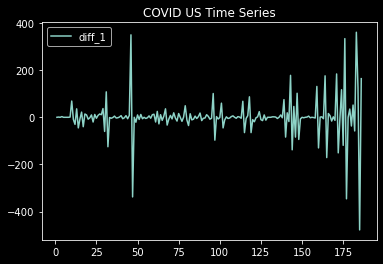

In [17]:
# plot the difference
time_us['diff_1'] = time_us.confirmed_cases - time_us.confirmed_cases.shift()

time_us.plot(y=['diff_1'])
plt.title('COVID US Time Series')
plt.show()

In [18]:
# create plotly figure object
fig = go.Figure()

# add trace for first line plot of cases each time entry
fig.add_trace(go.Scatter(
    x=time_us.update_time,
    y=time_us.diff_1,
    mode='lines',
    name='new cases',
))

---
2. Generate and interpret a PACF for the time series (and/or its differences).

> PACF for time series

Text(0.5, 1.0, 'US COVID PACF')

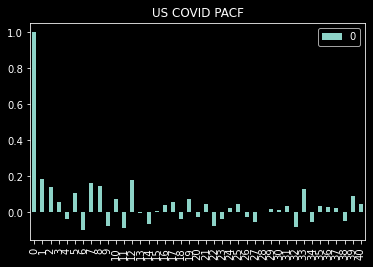

In [41]:
x_acf = pd.DataFrame(pacf(time_us.confirmed_cases))
x_acf.plot(kind='bar')
plt.title("US COVID PACF")

Text(0.5, 1.0, 'US COVID Diff PACF')

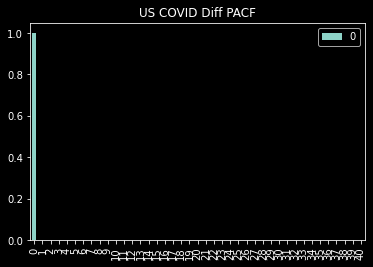

In [40]:
x_acf = pd.DataFrame(pacf(time_us.diff_1))
x_acf.plot(kind='bar')
plt.title("US COVID Diff PACF")

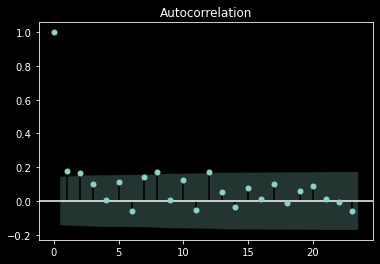

In [39]:
fig = plot_acf(time_us.confirmed_cases)

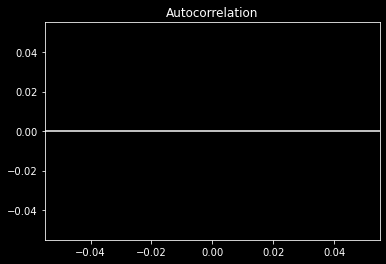

In [38]:
fig = plot_acf(time_us.diff_1)

> The PACF graph shows that 1 is highly correlated and is a possible p value

---
3. Generate five ARIMA specifications and evaluate their efficacy at modeling your data.

                              ARMA Model Results                              
Dep. Variable:        confirmed_cases   No. Observations:                  187
Model:                     ARMA(0, 1)   Log Likelihood               -1042.239
Method:                       css-mle   S.D. of innovations             63.718
Date:                Mon, 15 Feb 2021   AIC                           2090.478
Time:                        22:19:07   BIC                           2100.171
Sample:                             0   HQIC                          2094.405
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    29.5439      5.342      5.531      0.000      19.074      40.014
ma.L1.confirmed_cases     0.1472      0.066      2.223      0.026       0.017       0.277
        

Text(0.5, 1.0, 'Histogram of Residuals')

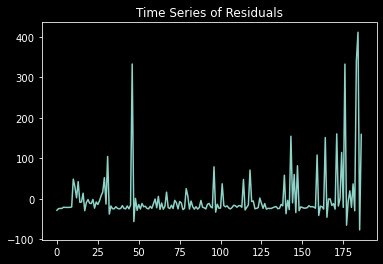

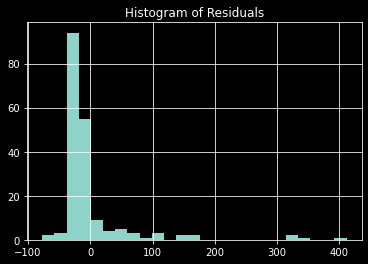

In [52]:
model = ARIMA(time_us.confirmed_cases, order=(0,0,1))
model_fit = model.fit()
print(model_fit.summary())
print("Residuals Description")
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title("Time Series of Residuals")

residuals.hist(bins=25)
plt.title("Histogram of Residuals")

                              ARMA Model Results                              
Dep. Variable:        confirmed_cases   No. Observations:                  187
Model:                     ARMA(1, 0)   Log Likelihood               -1041.543
Method:                       css-mle   S.D. of innovations             63.479
Date:                Mon, 15 Feb 2021   AIC                           2089.085
Time:                        22:18:57   BIC                           2098.778
Sample:                             0   HQIC                          2093.013
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    29.5828      5.688      5.201      0.000      18.434      40.732
ar.L1.confirmed_cases     0.1849      0.073      2.541      0.011       0.042       0.327
        

Text(0.5, 1.0, 'Histogram of Residuals')

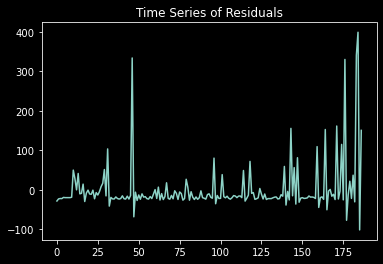

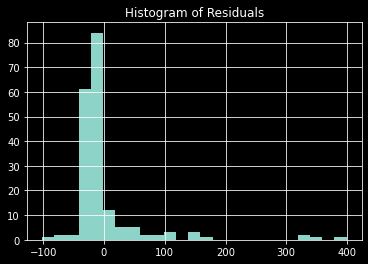

In [51]:
model = ARIMA(time_us.confirmed_cases, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print("Residuals Description")
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title("Time Series of Residuals")

residuals.hist(bins=25)
plt.title("Histogram of Residuals")

                              ARMA Model Results                              
Dep. Variable:        confirmed_cases   No. Observations:                  187
Model:                     ARMA(2, 0)   Log Likelihood               -1039.767
Method:                       css-mle   S.D. of innovations             62.873
Date:                Mon, 15 Feb 2021   AIC                           2087.535
Time:                        22:19:21   BIC                           2100.459
Sample:                             0   HQIC                          2092.772
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    29.6596      6.522      4.548      0.000      16.877      42.443
ar.L1.confirmed_cases     0.1587      0.073      2.164      0.030       0.015       0.302
ar.L2.co

Text(0.5, 1.0, 'Histogram of Residuals')

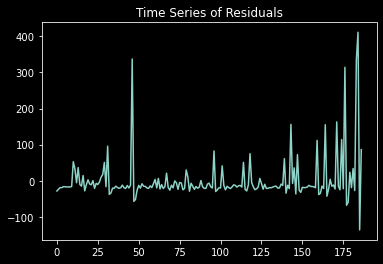

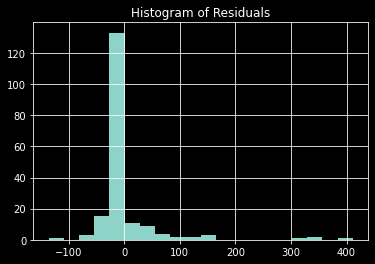

In [53]:
model = ARIMA(time_us.confirmed_cases, order=(2,0,0))
model_fit = model.fit()
print(model_fit.summary())
print("Residuals Description")
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title("Time Series of Residuals")

residuals.hist(bins=20)
plt.title("Histogram of Residuals")

                             ARIMA Model Results                              
Dep. Variable:     D2.confirmed_cases   No. Observations:                  185
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1081.177
Method:                       css-mle   S.D. of innovations             82.363
Date:                Mon, 15 Feb 2021   AIC                           2168.354
Time:                        22:19:35   BIC                           2178.015
Sample:                             2   HQIC                          2172.270
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0208      0.112      0.185      0.853      -0.200       0.241
ma.L1.D2.confirmed_cases    -1.0000      0.013    -75.014      0.000      -1.026      -0.

Text(0.5, 1.0, 'Histogram of Residuals')

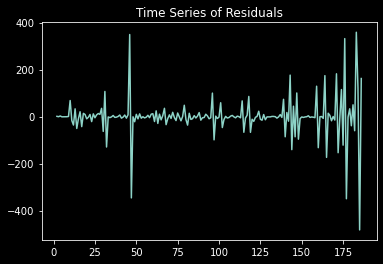

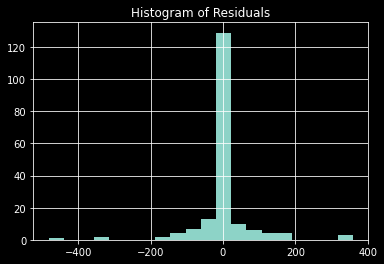

In [54]:
model = ARIMA(time_us.confirmed_cases, order=(0,2,1))
model_fit = model.fit()
print(model_fit.summary())
print("Residuals Description")
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title("Time Series of Residuals")

residuals.hist(bins=20)
plt.title("Histogram of Residuals")

                             ARIMA Model Results                              
Dep. Variable:     D2.confirmed_cases   No. Observations:                  185
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1123.950
Method:                       css-mle   S.D. of innovations            105.069
Date:                Mon, 15 Feb 2021   AIC                           2253.900
Time:                        22:20:05   BIC                           2263.561
Sample:                             2   HQIC                          2257.816
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.5524      4.543     -0.122      0.903      -9.457       8.352
ar.L1.D2.confirmed_cases    -0.7043      0.057    -12.253      0.000      -0.817      -0.

Text(0.5, 1.0, 'Histogram of Residuals')

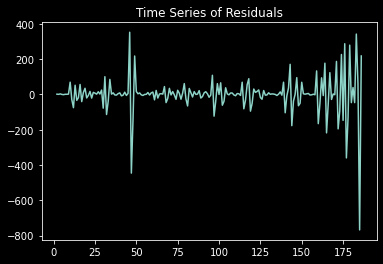

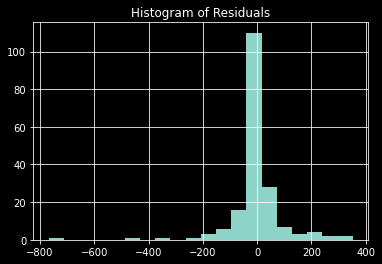

In [56]:
model = ARIMA(time_us.confirmed_cases, order=(1,2,0))
model_fit = model.fit()
print(model_fit.summary())
print("Residuals Description")
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title("Time Series of Residuals")

residuals.hist(bins=20)
plt.title("Histogram of Residuals")

                             ARIMA Model Results                              
Dep. Variable:      D.confirmed_cases   No. Observations:                  186
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -1031.213
Method:                       css-mle   S.D. of innovations             61.606
Date:                Mon, 15 Feb 2021   AIC                           2072.425
Time:                        22:21:19   BIC                           2088.554
Sample:                             1   HQIC                          2078.961
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6156      0.490      1.255      0.209      -0.346       1.577
ma.L1.D.confirmed_cases    -0.8793      0.074    -11.954      0.000      -1.024      -0.735


Text(0.5, 1.0, 'Histogram of Residuals')

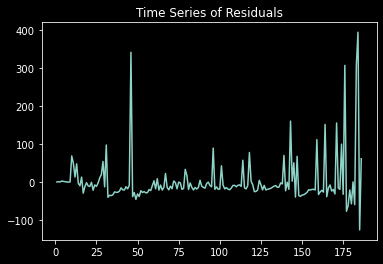

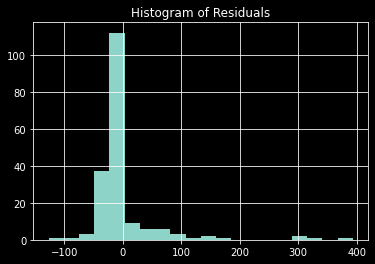

In [63]:
model = ARIMA(time_us.confirmed_cases, order=(0,1,3))
model_fit = model.fit()
print(model_fit.summary())
print("Residuals Description")
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title("Time Series of Residuals")

residuals.hist(bins=20)
plt.title("Histogram of Residuals")

---
> 4. Finally, choose one specification and make a case for it as a logical model for your dataset.

                             ARIMA Model Results                              
Dep. Variable:     D2.confirmed_cases   No. Observations:                  185
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1081.177
Method:                       css-mle   S.D. of innovations             82.363
Date:                Mon, 15 Feb 2021   AIC                           2168.354
Time:                        22:24:24   BIC                           2178.015
Sample:                             2   HQIC                          2172.270
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0208      0.112      0.185      0.853      -0.200       0.241
ma.L1.D2.confirmed_cases    -1.0000      0.013    -75.014      0.000      -1.026      -0.

Text(0.5, 1.0, 'Histogram of Residuals')

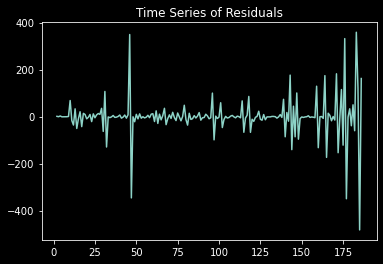

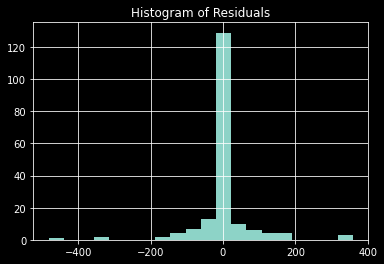

In [74]:
model = ARIMA(time_us.confirmed_cases, order=(0,2,1))
model_fit = model.fit()
print(model_fit.summary())
print("Residuals Description")
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title("Time Series of Residuals")

residuals.hist(bins=20)
plt.title("Histogram of Residuals")